<a href="https://colab.research.google.com/github/Volodimirich/Advance_ML/blob/main/Shaposhnikov_Vladimir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [228]:
#!pip3 install wget


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [229]:
import wget 
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import multivariate_normal
import seaborn as sns


%matplotlib inline

## Problem 1

Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

In [230]:
if not os.path.exists('owid-covid-data.csv'):
    wget.download('https://covid.ourworldindata.org/data/owid-covid-data.csv', '.') 

In [231]:
data = pd.read_csv("./owid-covid-data.csv")
data = data[(data["location"] == "Russia") & (data["date"] >= "2020-03-03")]
data

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
214873,RUS,Europe,Russia,2020-03-03,3.0,1.0,0.143,NaN,0.0,0.000,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
214874,RUS,Europe,Russia,2020-03-04,3.0,0.0,0.143,NaN,0.0,0.000,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
214875,RUS,Europe,Russia,2020-03-05,3.0,0.0,0.143,NaN,0.0,0.000,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
214876,RUS,Europe,Russia,2020-03-06,4.0,1.0,0.286,NaN,0.0,0.000,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
214877,RUS,Europe,Russia,2020-03-07,4.0,0.0,0.286,NaN,0.0,0.000,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215971,RUS,Europe,Russia,2023-03-06,22353291.0,11163.0,12939.143,396336.0,38.0,38.714,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
215972,RUS,Europe,Russia,2023-03-07,22363740.0,10449.0,13038.571,396378.0,42.0,39.714,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
215973,RUS,Europe,Russia,2023-03-08,NaN,NaN,NaN,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
215974,RUS,Europe,Russia,2023-03-09,NaN,NaN,NaN,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN


In [232]:
data = pd.read_csv("./owid-covid-data.csv")
data = data[(data["location"] == "Russia") & (data["date"] >= "2020-03-03")]
data = data[["date", "total_cases", "new_cases"]]

data['new_cases'] = data['new_cases'].replace(0, 1)
data.dropna(inplace=True)

data.sort_values(by="date", inplace=True)
data.reset_index(drop=True, inplace=True)

In [233]:
data

,date,total_cases,new_cases
0,2020-03-03,3.0,1.0
1,2020-03-04,3.0,1.0
2,2020-03-05,3.0,1.0
3,2020-03-06,4.0,1.0
4,2020-03-07,4.0,1.0
...,...,...,...
1095,2023-03-03,22314520.0,14516.0
1096,2023-03-04,22328569.0,14049.0
1097,2023-03-05,22342128.0,13559.0
1098,2023-03-06,22353291.0,11163.0


In [234]:
train_size = 50 
train, test = data.iloc[:train_size, :], data.iloc[train_size:, :]

In [235]:
train.tail(5)

,date,total_cases,new_cases
45,2020-04-17,32008.0,4070.0
46,2020-04-18,36793.0,4785.0
47,2020-04-19,42853.0,6060.0
48,2020-04-20,47121.0,4268.0
49,2020-04-21,52763.0,5642.0


In [236]:
test.head(5)

,date,total_cases,new_cases
50,2020-04-22,57999.0,5236.0
51,2020-04-23,62773.0,4774.0
52,2020-04-24,68622.0,5849.0
53,2020-04-25,74588.0,5966.0
54,2020-04-26,80949.0,6361.0


## Problem 2

Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.


*   Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня
*   Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня
*   Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).



In [237]:
def plot_graph(values, y_name, title, x_name='День', size = (12,6)):
    plt.figure(figsize=size)
    plt.plot(values)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title(title)

    plt.grid()
    plt.plot()


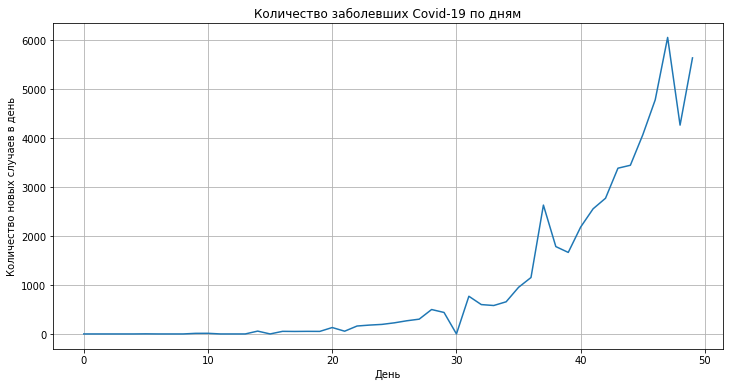

In [238]:
plot_graph(values=train["new_cases"].values, 
           y_name='Количество новых случаев в день', 
           title='Количество заболевших Covid-19 по дням')

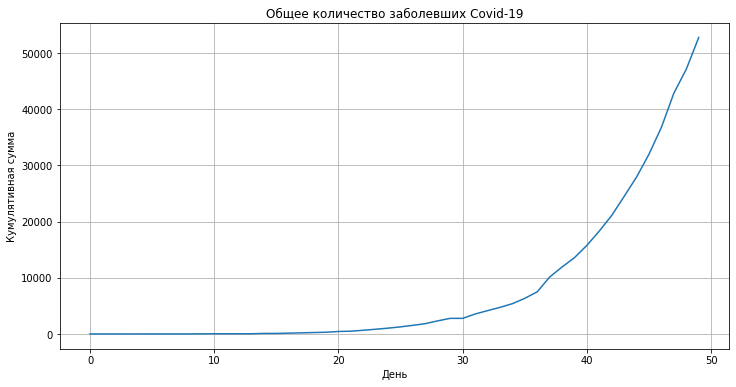

In [239]:
plot_graph(values=train["total_cases"].values, 
           y_name='Кумулятивная сумма', 
           title='Общее количество заболевших Covid-19' )

In [240]:
y_train_log, y_test_log = np.log(train["total_cases"].values), \
                                np.log(test["total_cases"].values)
X_train, X_test = np.array(train.index).reshape(-1, 1), \
                    np.array(test.index).reshape(-1, 1)

In [241]:
clf = LinearRegression()
clf.fit(X_train, y_train_log)
y_pred = clf.predict(X_test)

[]

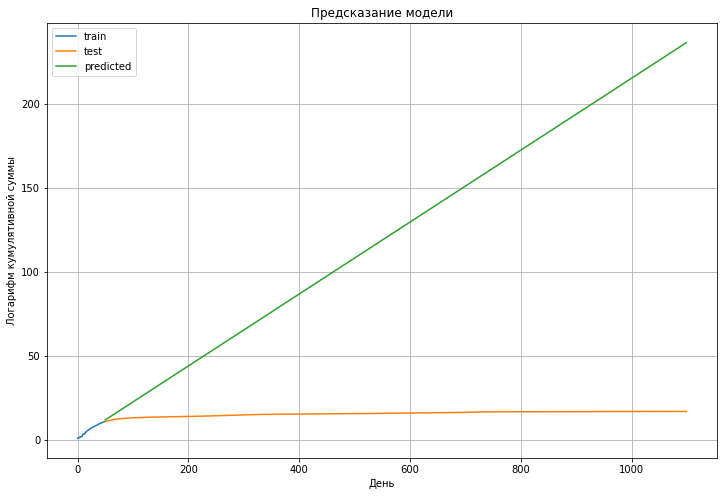

In [242]:
plt.figure(figsize=(12, 8))
plt.plot(X_train, y_train_log, label="train")
plt.plot(X_test, y_test_log, label="test")
plt.plot(X_test, y_pred, label="predicted")

plt.xlabel("День")
plt.ylabel("Логарифм кумулятивной суммы")
plt.title("Предсказание модели")

plt.legend()
plt.grid()
plt.plot()

In [243]:
noize = np.std(y_train_log - clf.predict(X_train))
sigma = 100 * np.eye(2)
X_train_intercept = np.hstack((np.ones(X_train.shape[0]).reshape(-1, 1), 
                               X_train.reshape(-1, 1)))

In [244]:
def bayesian_update(mu_init, sigma_init, x, y, sigma_noise):
    sigma = np.linalg.inv(np.linalg.inv(sigma_init) + (1 / (sigma_noise ** 2)) * np.matmul(x.T, x))
    mu = np.matmul(sigma, np.matmul(np.linalg.inv(sigma_init), mu_init.T) + \
                   (1 / (sigma_noise ** 2)) * np.matmul(x.T, y))
    return mu, sigma

In [245]:
mu, sigma = bayesian_update(np.zeros((2,)), sigma, X_train_intercept, 
                            y_train_log, noize)
print(f"mu={mu}")
print(f"sigma={sigma}")

mu=[1.19323277 0.21411201]
sigma=[[ 1.57133653e-02 -4.76162561e-04]
 [-4.76162561e-04  1.94359933e-05]]


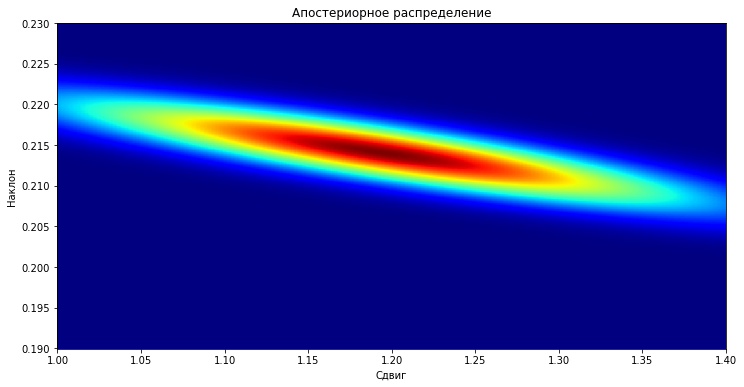

In [246]:
N = 500
X = np.linspace(1, 1.4, N)
Y = np.linspace(0.19, 0.23, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0], pos[:, :, 1] = X, Y

Z = multivariate_normal.pdf(pos, mean=mu, cov=sigma)

plt.figure(figsize=(12, 6))
plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
plt.title("Апостериорное распределение")
plt.xlabel("Сдвиг")
plt.ylabel("Наклон");

In [247]:
def plot_several_graphs(x_vector, y_vector, labels, title, y_name, x_name='День', is_plt_created=False):
    if not is_plt_created:
        plt.figure(figsize=(12, 6))

    for x, y, label_name in zip(x_vector, y_vector, labels):
        plt.plot(x, y, label=label_name)
    plt.title(title)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.legend()
    plt.grid()

(0.0, 400.0)

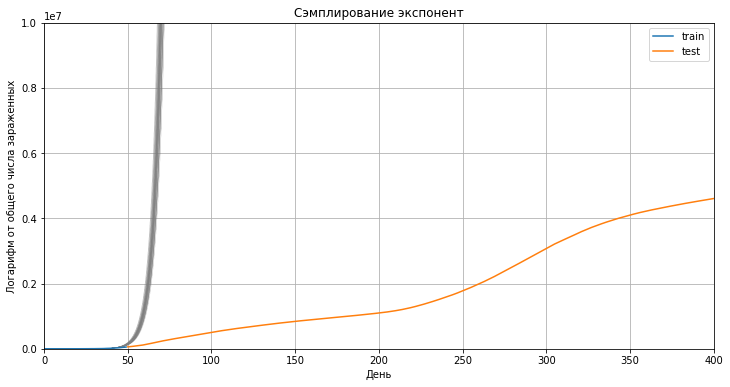

In [248]:
N = 100
weights = np.random.multivariate_normal(mu, sigma, N)

plt.figure(figsize=(12, 6))


x_sampled = np.arange(data.shape[0])
for b, w in weights:
    plt.plot(x_sampled, np.exp(b + w * x_sampled), color='gray', lw=0.1)

plot_several_graphs([X_train, X_test], [np.exp(y_train_log), np.exp(y_test_log)], 
                    ['train', 'test'], 'Сэмплирование экспонент', 
                    'Логарифм от общего числа зараженных', is_plt_created=True)

plt.ylim((0, 1e7))
plt.xlim((0, 400))  

In [249]:
res = [data.loc[data["date"] == date] for date 
       in ["2020-05-01", "2020-06-01", "2020-09-01"]]
info = []
for i, date in enumerate(["2020-05-01", "2020-06-01", "2020-09-01"]):
    day = data[data["date"] == date].index[0]
    day = np.array([[day]])
    pred_exp = np.exp(clf.predict(day))
    info.append((date, int(res[i]["total_cases"].values[0]),  int(pred_exp[0]), 
                 int(pred_exp - res[i]["total_cases"].values)))
pd.DataFrame(info, columns = ['Дата', 'Число заболевших', 
                              'Предсказанное значение', 'Разница'])

,Дата,Число заболевших,Предсказанное значение,Разница
0,2020-05-01,114431,1010236,895805
1,2020-06-01,414878,770840678,770425800
2,2020-09-01,1000048,276442156109051264,276442156108051200


In [250]:
def plot_predictive_distribution(X, date, n_samples=1000):
    days = X[X["date"] == date].index[0]
    weights = np.random.multivariate_normal(mu, sigma, n_samples)
    a, b = weights[:, 0], weights[:, 1]
    preds = np.exp(a + b * days)
    plt.hist(preds, bins=30)
    plt.title(f"Распределение {date}")
    plt.xlabel(f"Число заболевших")
    plt.ylabel("Частота")
    plt.show()

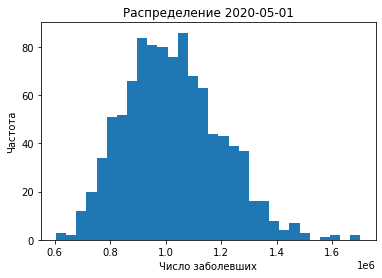

In [251]:
plot_predictive_distribution(data, "2020-05-01")

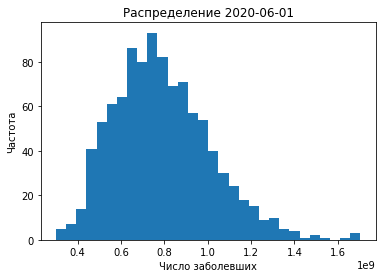

In [252]:
plot_predictive_distribution(data, "2020-06-01")

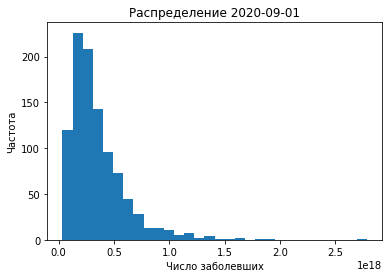

In [253]:
plot_predictive_distribution(data, "2020-09-01")

## Problem 3

Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана:

$$\large{Ф(x) = \frac{1}{\sqrt{2\pi}}\int\limits_{-\infty}^x e^{-\frac{t^2}{2}}\,dt} $$


Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.

*   Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.
*   Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.
*   Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?




$$Ф(x) = \frac{1}{\sqrt{2\pi}}\int\limits_{-\infty}^x e^{-\frac{t^2}{2}}\,dt$$
$$ t = wt + b \rightarrow t^2 = w_2t^2 + w_1t + w_0$$
$$Ф(x) = \frac{1}{\sqrt{2\pi}}\int\limits_{-\infty}^x e^{w_2't^2 + w_1't + w_0'}\,dt$$

В таком случае для y':
$$ y' = e^{w_2't^2 + w_1't + w_0'} $$
$$ ln(y') = w_2t^2 + w_1t + w_0 $$
Линейна относительно весов

In [254]:
# getting w2*t**2, w*t, w
get_poly_coeffs = lambda x: np.hstack((np.ones((x.shape[0])).reshape(-1, 1), x, x**2))
full_data = np.array(data.index).reshape(-1, 1)
X_train_poly = get_poly_coeffs(X_train)
X_poly = get_poly_coeffs(full_data)
y_train, y_test = train["new_cases"].values, test["new_cases"].values

In [255]:
pol_clf = LinearRegression(fit_intercept=False)
pol_clf.fit(X_train_poly, np.log(y_train))
preds = pol_clf.predict(X_poly)

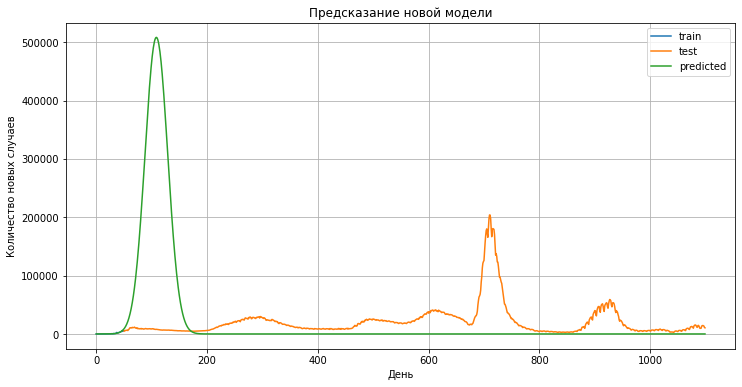

In [256]:
x_vector = [X_train, X_test, full_data]
y_vector = [y_train, y_test, np.exp(preds)]
label_list = ['train', 'test', 'predicted']

plot_several_graphs(x_vector, y_vector, label_list,
                    'Предсказание новой модели', 'Количество новых случаев')


In [257]:
noize = np.std(np.log(y_train) - pol_clf.predict(X_train_poly))
mu = np.zeros((3,))
sigma = 100 * np.eye(3)

mu, sigma = bayesian_update(mu, sigma, X_train_poly, np.log(y_train), noize)
print(f"mu={mu}")
print(f"sigma={sigma}")

mu=[-0.87043636  0.25810802 -0.00118733]
sigma=[[ 2.37447987e-01 -1.91843450e-02  3.22967855e-04]
 [-1.91843450e-02  2.11662617e-03 -4.04050781e-05]
 [ 3.22967855e-04 -4.04050781e-05  8.24816486e-07]]


<ipython-input-281-7feda6a4ddfe>:9: RuntimeWarning: overflow encountered in exp
  preds = np.exp(b + w1 * x_sampled + w2 * (x_sampled ** 2))
<ipython-input-281-7feda6a4ddfe>:18: RuntimeWarning: overflow encountered in accumulate
  sum_list = np.array(pred_list).cumsum(axis=1)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


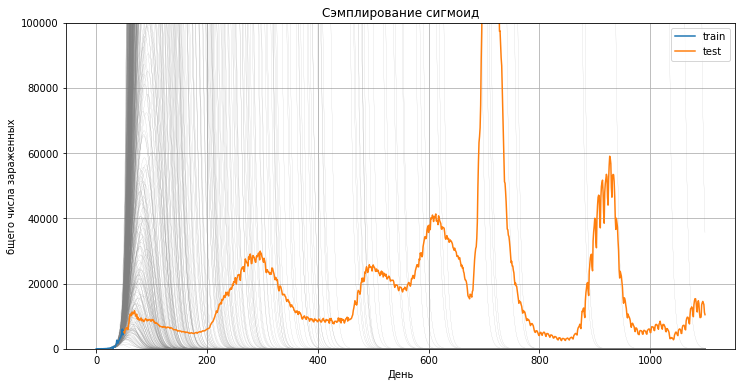

In [281]:
N = 400
weights = np.random.multivariate_normal(mu, sigma, N)

plt.figure(figsize=(12, 6))
pred_list = []

x_sampled = np.arange(data.shape[0])
for b, w1, w2 in weights:
    preds = np.exp(b + w1 * x_sampled + w2 * (x_sampled ** 2))
    pred_list.append(preds)
    plt.plot(x_sampled, preds, color='gray', lw=0.1)

plot_several_graphs([X_train, X_test], [y_train, y_test], 
                    ['train', 'test'], 'Сэмплирование сигмоид', 'бщего числа зараженных',
                    is_plt_created=True)

plt.ylim((0, 1e5))
sum_list = np.array(pred_list).cumsum(axis=1)

In [259]:
res = [data.loc[data["date"] == date] for date 
       in ["2020-05-01", "2020-06-01", "2020-09-01"]]

for i, date in enumerate(["2020-05-01", "2020-06-01", "2020-09-01"]):
    print("Дата:", date)
    print("Общее количество заболевших:", *res[i]["total_cases"].values)
    day = data[data["date"] == date].index[0]
    day = np.array([[day]])
    pred = sum_list[:, day]
    print("Предсказание пессимистичный сценарий:", int(np.percentile(pred, 90)))
    print("Предсказание оптимистичный сценарий:", int(np.percentile(pred, 10)))
    print()

Дата: 2020-05-01
Общее количество заболевших: 114431.0
Предсказание пессимистичный сценарий: 539470
Предсказание оптимистичный сценарий: 94251

Дата: 2020-06-01
Общее количество заболевших: 414878.0
Предсказание пессимистичный сценарий: 232535613
Предсказание оптимистичный сценарий: 273787

Дата: 2020-09-01
Общее количество заболевших: 1000048.0
Предсказание пессимистичный сценарий: 11370591823408200
Предсказание оптимистичный сценарий: 282311



In [290]:
sum_list

array([[7.39012926e-01, 1.61827861e+00, 2.66561518e+00, ...,
                   inf,            inf,            inf],
       [3.40284845e-01, 7.87892734e-01, 1.37509172e+00, ...,
        2.21731085e+07, 2.21731085e+07, 2.21731085e+07],
       [3.44472327e-01, 7.98998573e-01, 1.39699460e+00, ...,
        9.84537601e+06, 9.84537601e+06, 9.84537601e+06],
       ...,
       [3.09591736e-01, 7.28103954e-01, 1.29127953e+00, ...,
        2.80038642e+05, 2.80038642e+05, 2.80038642e+05],
       [2.20489502e-01, 5.13712330e-01, 9.02563471e-01, ...,
        2.18749233e+07, 2.18749233e+07, 2.18749233e+07],
       [4.42524424e-01, 1.03482307e+00, 1.82465221e+00, ...,
        1.98747912e+06, 1.98747912e+06, 1.98747912e+06]])

In [282]:
res = [data.loc[data["date"] == date] for date 
       in ["2020-05-01", "2020-06-01", "2020-09-01"]]
info = []
for i, date in enumerate(["2020-05-01", "2020-06-01", "2020-09-01"]):
    day = data[data["date"] == date].index[0]
    day = np.array([[day]])
    pred = sum_list[:, day]
    info.append((date, int(res[i]["total_cases"].values[0]), 
                 int(np.percentile(pred, 90)), 
                 int(np.percentile(pred, 10)),
                int(res[i]["total_cases"].values[0]) - int(np.percentile(pred, 10))))
pd.DataFrame(info, columns = ['Дата', 'Число заболевших', 
                              'Пессимистичное предсказание', 
                              'Оптимистичное предсказание', 'Разница с оптимистичным'])

,Дата,Число заболевших,Пессимистичное предсказание,Оптимистичное предсказание,Разница с оптимистичным
0,2020-05-01,114431,559632,92969,21462
1,2020-06-01,414878,206719316,294429,120449
2,2020-09-01,1000048,6080803227894458,325021,675027


Выводы:

Последний способ оказался намного эффективнее наивного и обычного экспонециального решения. Оптимистические показатели не сильно отличаются от реальных. Идейно можно взять значение перцентиля как гиперпараметр в данной задаче.